# Исследование влияния значений гиперпараметров на метрики качества обученной нейронной сети

**Проведите серию экспериментов по перебору гиперпараметров нейронной сети, созданной на занятии.**

1. Поменяйте количество нейронов в сети, используя следующие значения:

    - один слой 10 нейронов
    - один слой 100 нейронов
    - один слой 5000 нейронов

2. Поменяйте активационную функцию в скрытых слоях с `relu` на `linear`.

3. Поменяйте размеры `batch_size`:

    - 1
    - 10
    - 100
    - Вся база (60000)

4. Запишите в таблицу получившиеся точности.

5. Напишите выводы по результатам проведенных тестов.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import utils

from PIL import Image

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
try:
    from collections.abc import Iterable
except ImportError:
    from collections import Iterable

Количество эпох обучения:

In [3]:
EPOCHS = 15

Метрики качества:

In [4]:
precision = Precision()
recall = Recall()

## Подготовка данных

Загрузка данных MNIST

In [5]:
(x_train_org, y_train_org), (x_test_org, y_test_org) =\
    mnist.load_data()

In [6]:
print(x_train_org.shape)

(60000, 28, 28)


Контрольное отображение цифр из набора

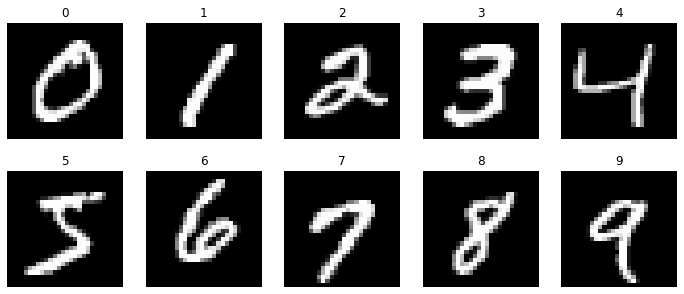

In [7]:
digits = np.unique(y_train_org)

_, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for digit, ax in zip(digits, axes):
    ax.imshow(
        Image.fromarray(x_train_org[y_train_org == digit][0]).convert('RGB')
    )

    ax.set_title(str(digit))
    ax.set_axis_off()

plt.show();

Изменить формат входных изображений

In [8]:
x_train = x_train_org.reshape(-1, 28*28).astype(np.float32) / 255
x_test = x_test_org.reshape(-1, 28*28).astype(np.float32) / 255

Преобразовать ответы в унитарный код (one-hot)

In [9]:
y_train = utils.to_categorical(y_train_org, 10)
y_test = utils.to_categorical(y_test_org, 10)

In [10]:
print(y_train.shape)

(60000, 10)


## Создание модели нейронной сети.

Определение вспомогательного класса для создания модели нейронной сети.

In [11]:
class NetBuilder:

    @staticmethod
    def build(layers, activation='relu'):
        if not layers or not isinstance(layers, Iterable):
            raise RuntimeError(f"Illegal layers collection {layers}")

        model = Sequential()
        # Добавить скрытые слои нейронной сети
        for i, n in enumerate(layers):
            if i == 0:
                layer = Dense(
                    n, input_dim=28*28, activation=activation
                )
            else:
                layer = Dense(
                    n, activation=activation
                )
            model.add(layer)

        # Добавить выходной слой нейронной сети
        model.add(
            Dense(10, activation='softmax')
        )

        return model

## 1 Проверка влияния числа нейронов

Создать датафрейм для хранения результатов тестирования.

In [12]:
report_n = pd.DataFrame(
    columns=['loss', 'accuracy', 'precision', 'recall', 'f1']
)
report_n.index.name = "Количество нейронов"

### 1.1 10 нейронов в скрытом слое

Создание модели нейронной сети с 10 нейронами в скрытом слое.

In [13]:
model_n10 = NetBuilder.build(layers=(800, 10))
model_n10.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy', precision, recall]
)

print(model_n10.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 800)               628000    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                8010      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
Total params: 636,120
Trainable params: 636,120
Non-trainable params: 0
_________________________________________________________________
None


Обучение нейронной сети.

In [14]:
history_n10 = model_n10.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/15
469/469 [==============================] - 3s 7ms/step - loss: 0.3393 - accuracy: 0.9025 - precision: 0.9509 - recall: 0.8633    

Отобразить изменение loss и метрик качества в процессе обучения.

In [15]:
def plot_history(history):
    _, axes = plt.subplots(2, 2, figsize=(12, 12))

    axes = axes.flatten()

    axes[0].plot(
        history.epoch,
        history.history['loss'],
        color='steelblue'
    )
    axes[0].set_ylabel('loss')
    axes[0].set_xlabel('epoch')
    axes[0].grid(True)

    axes[1].plot(
        history.epoch,
        history.history['accuracy'],
        color='salmon'
    )
    axes[1].set_ylabel('accuracy')
    axes[1].set_xlabel('epoch')
    axes[1].grid(True)

    axes[2].plot(
        history.epoch,
        history.history['precision'],
        color='seagreen'
    )
    axes[2].set_ylabel('precision')
    axes[2].set_xlabel('epoch')
    axes[2].grid(True)

    axes[3].plot(
        history.epoch,
        history.history['recall'],
        color='forestgreen'
    )
    axes[3].set_ylabel('precision')
    axes[3].set_xlabel('epoch')
    axes[3].grid(True)

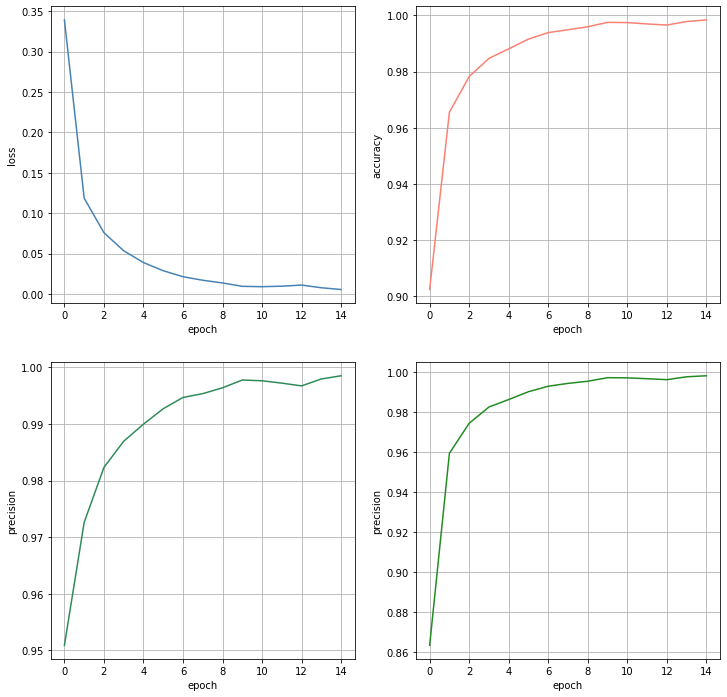

In [16]:
plot_history(history_n10)
plt.show();

Оценить loss и метрики качества на тестовой выборке.

In [17]:
def make_report(model: Sequential, df: pd.DataFrame, row):
    score = model.evaluate(x_test, y_test, verbose=1)

    print(f"\nTest score: {score[0]}")
    print(f"Test accuracy: {score[1]}")
    print(f"Test precision: {score[2]}")
    print(f"Test recall: {score[3]}")

    df.loc[row, :] = [
        score[0],
        score[1],
        score[2],
        score[3],
        2 * score[2] * score[3] / (score[2] + score[3])
    ]

In [18]:
make_report(model_n10, report_n, 10)

313/313 [==============================] - 1s 3ms/step - loss: 0.0978 - accuracy: 0.9788 - precision: 0.9796 - recall: 0.9784

### 1.2 100 нейронов в скрытом слое

Создание модели нейронной сети с 10 нейронами в скрытом слое.

In [19]:
model_n100 = NetBuilder.build(layers=(800, 100))
model_n100.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy', precision, recall]
)

print(model_n100.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 800)               628000    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               80100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 709,110
Trainable params: 709,110
Non-trainable params: 0
_________________________________________________________________
None


Обучение нейронной сети.

In [20]:
history_n100 = model_n100.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/15
469/469 [==============================] - 5s 10ms/step - loss: 0.2283 - accuracy: 0.9328 - precision: 0.9593 - recall: 0.9214

Отобразить изменение loss и метрик качества в процессе обучения.

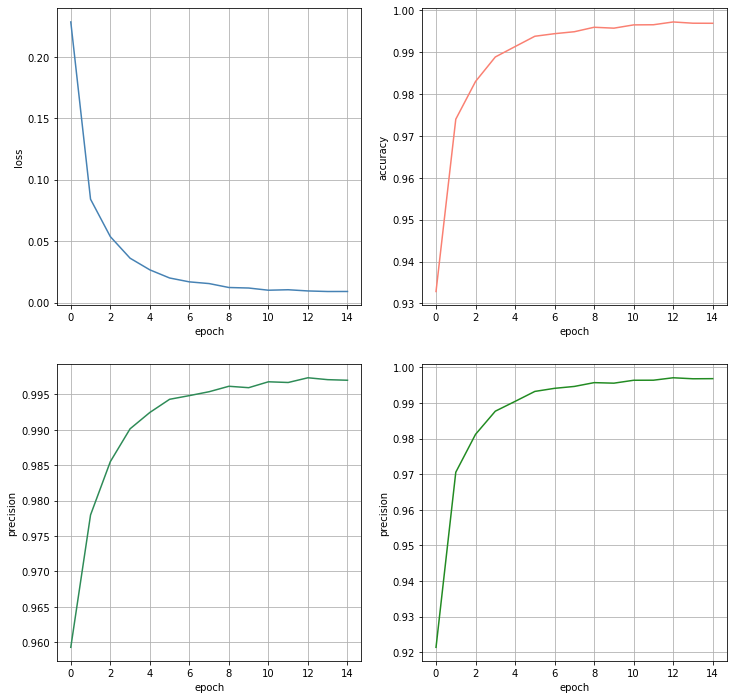

In [21]:
plot_history(history_n100)
plt.show();

Оценить loss и метрики качества на тестовой выборке.

In [22]:
make_report(model_n100, report_n, 100)




313/313 [==============================] - 1s 4ms/step - loss: 0.0905 - accuracy: 0.9803 - precision: 0.9808 - recall: 0.9798